# Info

This is data simulation script for simulated rotation data used in the evaluation of fedRBE.

In [6]:
library(devtools)
# install_github("mwgrassgreen/RobNorm")

In [7]:
library(limma)
library(reshape2)
library(gridExtra)

source("../../evaluation_utils/plots_eda.R")
source("../../evaluation_utils/simulation_func.R")


# Settings

Parameters set to generate simulated data with 600 samples and 6000 proteins.

In [8]:
generate_metadata <- function(batch_info, mode){

    if (mode == "balanced"){
        # Create batch assignments for each group
        batches <- rep(c("batch1", "batch2", "batch3"), each = 100)
        # Combine batch assignments
        batch_info$condition <- as.factor(c(rep("A", 300), rep("B", 300)))
        batch_info$batch <- as.factor(c(batches[sample(1:300)], batches[sample(1:300)]))
    # }
    } else if (mode == "strong_imbalanced") {
        # Strong imbalance
        # Create batch assignments for each group    
        batches_A <- c(rep("batch1", 32), rep("batch2", 28), rep("batch3", 288))
        batches_B <- c(rep("batch1", 8), rep("batch2", 52), rep("batch3", 192))
        # Combine batch assignments
        batch_info$condition <- as.factor(c(rep("A", length(batches_A)), rep("B", length(batches_B))))
        batch_info$batch <- as.factor(c(
            batches_A[sample(1:length(batches_A))], 
            batches_B[sample(1:length(batches_B))]))
    
    } else if(mode == "mild_imbalanced") {
        # Mild imbalance
        # Create batch assignments for each group    
        batches_A <- c(rep("batch1", 36), rep("batch2", 91), rep("batch3", 185))
        batches_B <- c(rep("batch1", 54), rep("batch2", 49), rep("batch3", 185))
        # Combine batch assignments
        batch_info$condition <- as.factor(c(rep("A", length(batches_A)), rep("B", length(batches_B))))
        batch_info$batch <- as.factor(c(
            batches_A[sample(1:length(batches_A))], 
            batches_B[sample(1:length(batches_B))]))
    }
    return(batch_info)

}

In [9]:
getwd()

[1] "/home/yuliya-cosybio/repos/cosybio/fedRBE/evaluation_data/simulated_rotation"

In [10]:
workdir <- "./"

number_of_runs = 1

mu_1 = 1.45
mu_4 = 1.25

frac_1 = 0.45
frac_7 = 0.15

# number of samples
m = 600

## generate data

In [11]:
check_dirs <- function(workdir){
    if (!dir.exists(workdir)){
        dir.create(workdir, recursive = TRUE)
    }
}

[1] "./balanced/before/intermediate"
[1] "Run simulation for mode: balanced"
[1] "Run number 1"
180 
[1] "Number of DE proteins: 2400\n Number of proteins: 6000\n"
   batch1    batch2    batch3 
0.7463850 4.7557397 0.2211491 
   batch1    batch2    batch3 
0.4347601 8.0794728 0.1754976 
[1] "./balanced/before/intermediate/1_intensities_data.tsv"
[1] "Run number 1"


Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


[1] "./mild_imbalanced/before/intermediate"
[1] "Run simulation for mode: mild_imbalanced"
[1] "Run number 1"
168 
[1] "Number of DE proteins: 2400\n Number of proteins: 6000\n"
   batch1    batch2    batch3 
4.4904658 0.2135587 6.6544248 
   batch1    batch2    batch3 
0.3542017 0.7031100 0.2033450 
[1] "./mild_imbalanced/before/intermediate/1_intensities_data.tsv"
[1] "Run number 1"


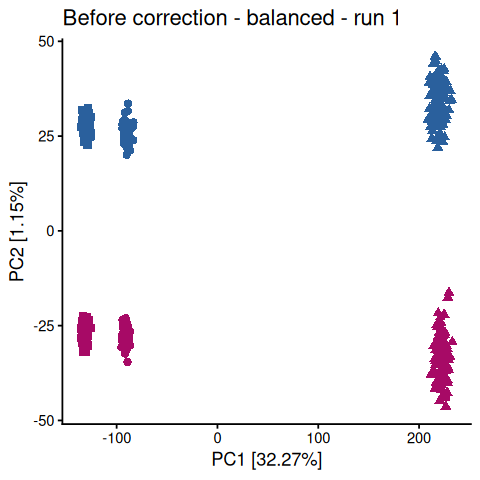

[1] "./strong_imbalanced/before/intermediate"
[1] "Run simulation for mode: strong_imbalanced"
[1] "Run number 1"
162 
[1] "Number of DE proteins: 2400\n Number of proteins: 6000\n"
   batch1    batch2    batch3 
5.3700658 0.4678982 0.9867114 
    batch1     batch2     batch3 
6.43425354 0.51901855 0.05502145 
[1] "./strong_imbalanced/before/intermediate/1_intensities_data.tsv"
[1] "Run number 1"


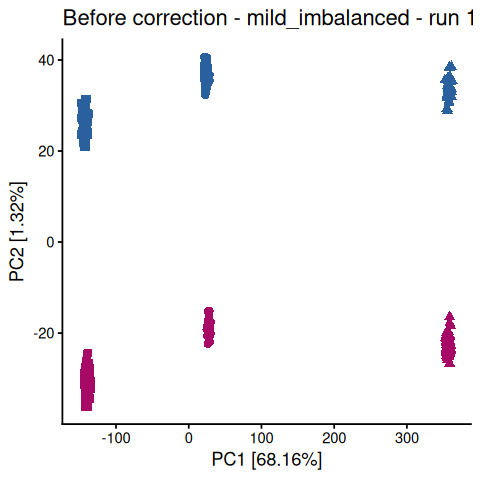

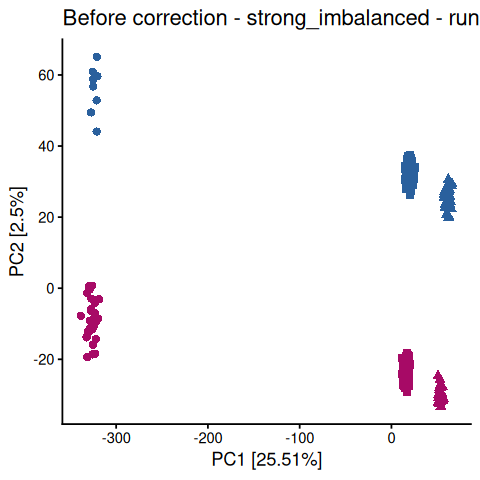

In [13]:
for (mode in c("balanced",
        "mild_imbalanced", 
        "strong_imbalanced"
    )){

    # select random seed
    set.seed(runif(1, 1, 10000))
    sub_path = mode

    # Set directories
    generated_data_directory <- paste0(workdir, sub_path, "/before/intermediate")
    print(generated_data_directory)
    check_dirs(generated_data_directory)

    # Create metadata
    batch_info <- data.frame(file = paste("s", 1:600, sep="."))
    rownames(batch_info) <- batch_info$file
    batch_info <- generate_metadata(batch_info, mode)
    # batch_info %>% group_by(batch, condition) %>%
    #     summarise(n = n()) %>% print()
    
    # Set parameters for simulation
    col_frac_A = length(batch_info[batch_info$condition == "A",]$file) / 600
    col_frac_B = length(batch_info[batch_info$condition == "B",]$file) / 600
    # cat(col_frac_A, "\n")
    # cat(col_frac_B)


    print(paste0("Run simulation for mode: ", mode))
    # Run simulation
    for(j in 1:number_of_runs){
        print(paste0("Run number ", j))
        set.seed(runif(1, 1, 10000))

        result <- generate_data(
            col_frac_A, col_frac_B,
            frac_1, frac_7,
            mu_1=mu_1, mu_4=mu_4,
            batch_info=batch_info,
            mode_version = mode,
            m = m
        ) %>% as.data.frame()
        
        number_DE <- frac_1*2500*2 + frac_7*1000

        rownames(result) <- c(paste0("prt", 1:length(rownames(result))))
        dim(result)
        print(paste0("Number of DE proteins: ", number_DE, "\n", " Number of proteins: ", nrow(result), "\n"))

        # second, add batch effects with rotation
        attr(batch_info, "rotation") <- list(batch = "batch2", angle_deg = 4, pc = 1)
        data_with_batch_effects <- add_batch_effect(
                as.matrix(result), batch_info,
                mean_additive = sample(c(3, 4.7, -4.5)),
                sd_additive = sample(c(1.5, 1.5, 2.5)),
                shape_multiplicative = sample(c(3, 1, 5))
            ) %>% 
            as.data.frame()

        # Add missing values
        # data_with_batch_effects_missing <- simulateMissingValues(data_with_batch_effects, alpha = 0.2, beta = 0.5)
        # sum(is.na(data_with_batch_effects_missing)) / (nrow(data_with_batch_effects_missing) * ncol(data_with_batch_effects_missing))
        data_with_batch_effects_missing <- data_with_batch_effects

        print(paste0(generated_data_directory, "/", j, "_intensities_data.tsv"))
        # save data without missing values as one file
        data_with_batch_effects %>% rownames_to_column("rowname") %>%
            write.table(paste0(generated_data_directory, "/", j, "_intensities_data.tsv"), sep = "\t", row.names = FALSE)
        # and data with them as one file
        # write.table(data_with_batch_effects_missing, paste0(generated_data_directory, "/", j, "_intensities_data_missing.tsv"), sep = "\t")
        # and data without batch effects as one file
        result %>% rownames_to_column("rowname") %>%
            write.table(paste0(generated_data_directory, "/", j, "_intensities_data_no_batch.tsv"), sep = "\t", row.names = FALSE)

        # if(j %% 10 == 0){
        if(j %% 1 == 0){
            print(paste0("Run number ", j))
            options(repr.plot.width=4, repr.plot.height=4)
            plot <- pca_plot(
                data_with_batch_effects_missing, batch_info,
                title = paste("Before correction - ", mode, " - run ", j, sep=""),
                quantitative_col_name = "file", 
                col_col = "condition", shape_col="batch", show_legend=F, cbPalette=c("#a70a66", "#2a609d"))
            print(plot)
            # save plot to file
            check_dirs(paste0(generated_data_directory, "/plots/"))
            ggsave(paste0(generated_data_directory, "/plots/", j, "_PCA_before_correction.png"), plot, width=4, height=4)
        }

    }
    batch_info$lab <- mutate(batch_info, 
        lab =ifelse(batch == "batch1", "lab1", 
            ifelse(batch == "batch2", "lab2", "lab3")))$lab
    batch_info$batch <- NULL
    # write batch info
    check_dirs(paste0(workdir, "/", mode))
    write.table(batch_info, paste0(workdir, "/", mode, "/all_metadata.tsv"), sep = "\t")
}